<a href="https://colab.research.google.com/github/MScharnberg/IntSys19/blob/master/IntSys19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IntSys19

Intelligent Systems

---

[@tobias.vossen](mailto:tobias.vossen@study.hs-duesseldorf.de)

1.   First things first
2.   Data
3.   Model
4.   Deployment
5.   Exit strategy

## 1. First things first

### Libraries

In [1]:
import datetime, os
print(datetime.datetime.now().strftime('Last run: %d.%m.%Y'))

Last run: 30.05.2020


In [2]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow_datasets as tfds
print('TensorFlow Datasets version:', tfds.__version__)

%load_ext tensorboard
from tensorboard import version
print('TensorBoard version:', version.VERSION)

TensorFlow version: 2.2.0
TensorFlow Datasets version: 2.1.0
TensorBoard version: 2.2.1


In [3]:
from tensorflow import keras
print('Keras version:', keras.__version__)

Keras version: 2.3.0-tf


In [4]:
import numpy as np
print('NumPy version:', np.__version__)

NumPy version: 1.18.4


In [0]:
%matplotlib inline 
from matplotlib import pyplot as plt

In [0]:
from timeit import default_timer as timer

### Environment

In [0]:
def environment():
  """Check hardware accelerator for training"""

  if not tf.test.gpu_device_name():
    print('Running on CPU')
  else:
    print('Running on GPU')

### Logging

In [0]:
def logging():
  """Create directory for logging"""

  logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y-%m-%d'))
  print('Logs will be written to', logdir)
  return tf.summary.create_file_writer(logdir)

## 2. Data

*   Choose dataset
*   Load dataset
*   Explore dataset
*   Preprocess dataset


In [0]:
# Global data parameter
bs = 64 #@param {type:"slider", min:64, max:256, step:64}
ds = 'mnist' # String identifier for dataset
dim = 28 # Image dimension

### Choose dataset

### Load dataset

In [0]:
def load_dataset(ds):
  """Load dataset by means of TFDS (TensorFlow Datasets)
  
  Args:
    dataset: str
  
  Returns:
    train: tf.data.Dataset
    test: tf.data.Dataset
  """

  (train, test) = tfds.load(ds,
                            split=['train[:50%]', 'test[:50%]'],
                            shuffle_files=True,
                            as_supervised=True)

  assert isinstance(train, tf.data.Dataset)
  assert isinstance(test, tf.data.Dataset)
  return train, test

### Explore dataset

In [0]:
def visualize(ds):
  """Visualize dataset
  
  Args:
    ds: tf.data.Dataset
  
  Returns:
    fig: plt.figure
  """

  ds = ds.unbatch()
  fig = plt.figure(figsize=(16, 16))
  i = 0
  for example in ds.take(36):
    fig.add_subplot(6, 6, i+1)
    plt.imshow(tf.squeeze(example[0], -1), cmap='gray')
    plt.axis('off')
    i = i+1
  plt.show()
  return fig

### Preprocess dataset

In [0]:
def normalize(image, label):
  """Normalize dataset 
  
  Normalize:
    Cast -> Normalize

  Args:
    image: tf.Tensor as Integer
    label: tf.Tensor as Integer
  
  Returns:
    image: tf.Tensor as Float
    label: tf.Tensor as Integer
  """

  image = tf.cast(image, tf.float32) # 0...255
  image = (image - 127.5) / 127.5 # -1...1
  return image, label

In [0]:
def preprocess(ds, shuffle=True, batch=True):
  """Preprocess dataset

  Preprocess: 
    Normalize -> Shuffle -> Batch
  
  Args:
    ds: tf.data.Dataset
    shuffle: boolean
    batch: boolean
  
  Returns:
    ds: tf.data.Dataset
  """

  ds = ds.map(normalize)
  if shuffle: ds = ds.shuffle(shuffle_size)
  if batch: ds = ds.batch(bs, drop_remainder=True)
  return ds

### Run data domain

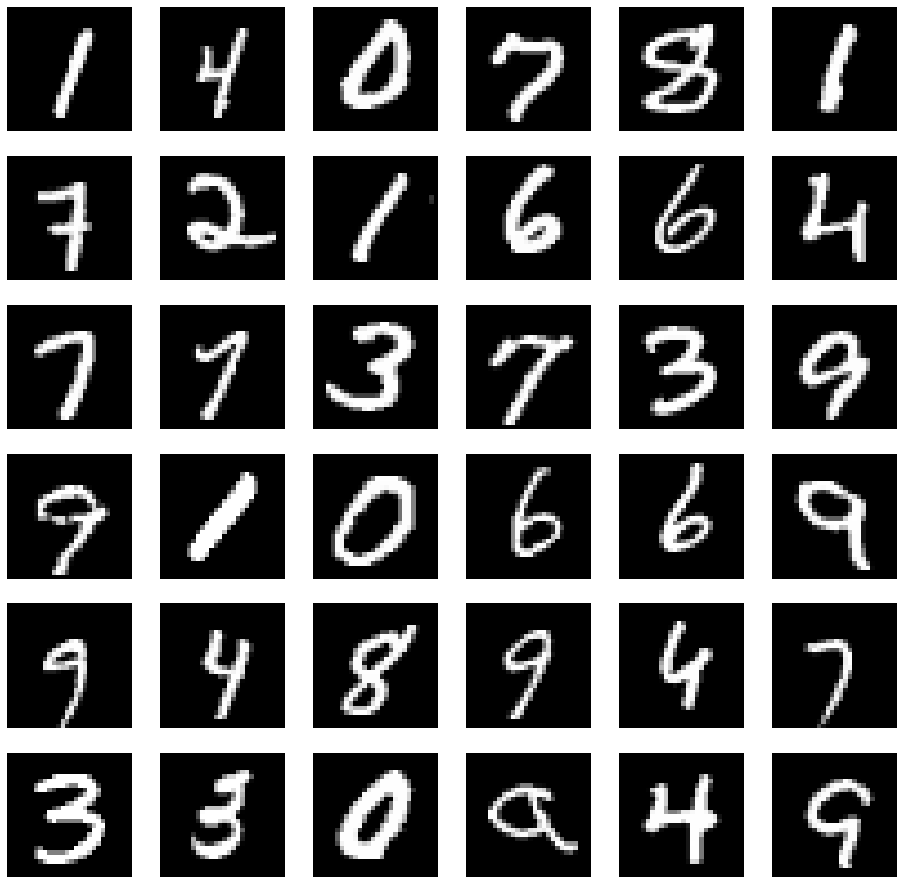

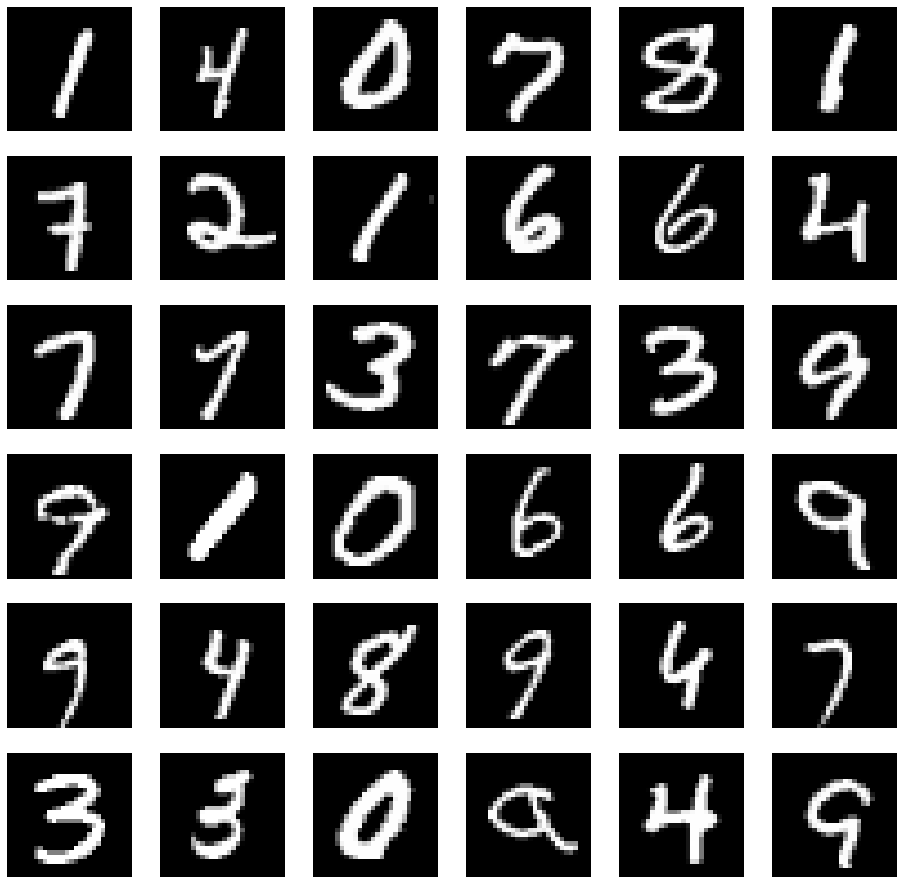

In [14]:
# Load dataset
train, test = load_dataset(ds)

# Preprocess dataset
train = preprocess(train, shuffle=False)
test = preprocess(test, shuffle=False)

# Visualize dataset
visualize(train)

## 3. Model

*   Choose model
*   Compile model
*   Train model
*   Evaluate model

In [0]:
# Global model parameter
epochs = 10 #@param {type:"slider", min:10, max:100, step:10}
lr = 1e-3 # Learning rate

### Choose model

#### Generator

In [0]:
def get_generator():
  """ Generator as faking model
  
  Architecture: Encoder-Decoder
    Input -> Dense -> Reshape -> Convolution -> Normalization -> Activation ->
    Inverse Convolution
              
  Returns:
    keras.Model
  """

  first = keras.Input(shape=(196, ))
  layer = keras.layers.Dense(196)(first)
  layer = keras.layers.Reshape((7, 7, 4))(layer)

  for i in range(2):
    layer = keras.layers.Conv2DTranspose(8*2**i, (3, 3), strides=2, padding='same')(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.LeakyReLU()(layer)
  
  last = keras.layers.Conv2DTranspose(1, (3, 3), strides=1, padding='same', activation='tanh')(layer)

  return keras.Model(inputs=first, outputs=last, name='Generator')

#### Discriminator

In [0]:
def get_discriminator():
  """ Discriminator as expertise model
  
  Architecture: Encoder
    Input -> Convolution -> Normalization -> Activation -> Flatten -> Dense
              
  Returns:
    keras.Model
  """

  first = keras.Input(shape=(dim, dim, 1))
  layer = first

  for i in reversed(range(2)):
    layer = keras.layers.Conv2D(8*2**i, (3, 3), strides=2, padding='same')(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.LeakyReLU()(layer)

  layer = keras.layers.Flatten()(layer)
  layer = keras.layers.Dense(98)(layer)
  last = keras.layers.Dense(1)(layer)

  return keras.Model(inputs=first, outputs=last, name='Discriminator')

In [18]:
get_generator()

### Compile model

In [0]:
def objective():
  """Binary crossentropy objective function
  
  Returns:
    keras.losses 
  """

  return keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def generator_loss(fake_output):
  """Generator loss
  
  Returns:
    generator_loss: tf.Tensor as Float
  """

  generator_loss = loss_fn(tf.ones_like(fake_output), fake_output)
  return generator_loss

In [0]:
def discriminator_loss(real_output, fake_output):
  """Discriminator loss
  
  Returns:
    discriminator_loss: tf.Tensor as Float
    loss_quotient: tf.Tensor as Float
  """

  real_loss = loss_fn(tf.ones_like(real_output), real_output)
  fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
  discriminator_loss = real_loss + fake_loss
  loss_quotient = real_loss / fake_loss
  return discriminator_loss, loss_quotient

In [0]:
def optimizer(learning_rate=lr):
  """Adam optimizer with exponential decay, as learning rate decreases over time
  
  Args:
    learning_rate: tf.float32
  
  Returns:
    keras.optimizer
  """
  
  schedule = keras.optimizers.schedules.ExponentialDecay(
      learning_rate,
      decay_steps=10,
      decay_rate=0.96)

  return tf.keras.optimizers.Adam(schedule)

### Train model

In [0]:
def train_step(images, noise):
  """Train step
  
  Step:
    Generate fake images -> Update evaluation metrics -> Let Discriminator
    classify -> Compute losses -> Update loss metrics -> Compute gradients ->
    Apply gradients

  Args:
    images: tf.Tensor as Float
      Real data distribution
    noise: tf.Tensor as Float
      Imaginary data distribution
  """

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    generated_images = generator(noise, training=True)

    metrics['eval/kld'].update_state(images, generated_images)
    metrics['eval/mse'].update_state(images, generated_images)
    
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    metrics['loss/generator'].update_state(gen_loss)
    disc_loss, realVSfake = discriminator_loss(real_output, fake_output)
    metrics['loss/discriminator'].update_state(disc_loss)
    metrics['loss/realVSfake'].update_state(realVSfake)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  optimizer().apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  optimizer().apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train_model(dataset):
  """Train model
  
  Train:
    Iterate over epochs -> Iterate over batches -> Train step per batch ->
    Save (and reset) metrics

  Args:
    images: tf.data.Dataset
  """
  
  environment()

  for epoch in range(1, epochs+1): # Iterate over epochs

    start = timer()
    print('Start of epoch %i of %i epochs' % (epoch, epochs))

    for batch in dataset: # Iterate over batches
      image_batch = batch[0]
      noise = tf.random.normal([bs, 196])
      train_step(image_batch, noise)

    with summary_writer.as_default(): # Save (and reset) metrics
      tf.summary.histogram('input/noise', noise[-1], step=epoch)
      tf.summary.image('output/digit', generator(tf.expand_dims(noise[-1], 0), training=False), step=epoch)
      tf.summary.scalar('optimizer/lr', optimizer().lr(epoch), step=epoch)

      for key, metric in metrics.items(): # Loss metrics
        tf.summary.scalar(key, metric.result(), step=epoch) 
        metric.reset_states()

    print('Time for epoch %i is %is' % (epoch, timer()-start))

### Evaluate model

In [25]:
summary_writer = logging()

Logs will be written to logs/2020-05-30


In [0]:
metrics = {
  'loss/generator' : keras.metrics.Mean(),
  'loss/discriminator' : keras.metrics.Mean(),
  'loss/realVSfake' : keras.metrics.Mean(),
  'eval/kld' : keras.metrics.KLDivergence(),
  'eval/mse' : keras.metrics.MeanSquaredError()
}

### Run model domain

In [27]:
generator = get_generator()
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 196)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               38612     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 8)         296       
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 8)         32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 16)        11

In [28]:
discriminator = get_discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 8)           32        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 8)         

In [0]:
loss_fn = objective()

In [30]:
train_model(train)

Running on GPU
Start of epoch 1 of 10 epochs
Time for epoch 1 is 42s
Start of epoch 2 of 10 epochs
Time for epoch 2 is 42s
Start of epoch 3 of 10 epochs
Time for epoch 3 is 42s
Start of epoch 4 of 10 epochs
Time for epoch 4 is 41s
Start of epoch 5 of 10 epochs
Time for epoch 5 is 41s
Start of epoch 6 of 10 epochs
Time for epoch 6 is 42s
Start of epoch 7 of 10 epochs
Time for epoch 7 is 41s
Start of epoch 8 of 10 epochs
Time for epoch 8 is 42s
Start of epoch 9 of 10 epochs
Time for epoch 9 is 42s
Start of epoch 10 of 10 epochs
Time for epoch 10 is 43s


In [0]:
board = False #@param ["False", "True"] {type:"raw"}
if board: # Visualize metrics in TensorBoard
  %tensorboard --logdir logs/

## 4. Deployment


In [0]:
# Global deployment parameter

### Use model

In [0]:
def predict():
  """ Generate digits

  Predict:
    Prediction -> Visualization 

  Returns:
    plt.fig
  """

  fig = plt.figure(figsize=(16, 16))

  for i in range(36): # Generate 36 digits
    fig.add_subplot(6, 6, i+1)
  
    # Prediction
    noise = tf.random.normal([1, 196]) # (bs, 196)
    prediction = generator(noise, training=False) # (bs, 28, 28, 1)

    # Visualization
    prediction = tf.squeeze(prediction, 0) # (28, 28, 1)
    plt.imshow(tf.squeeze(prediction, -1), cmap='gray') # (28, 28)
    plt.axis('off')

  plt.show()
  return fig

### Export model

In [0]:
export = False #@param ["False", "True"] {type:"raw"}
if export: # Export model
  model.save('./generator.h5')

### Run deployment domain

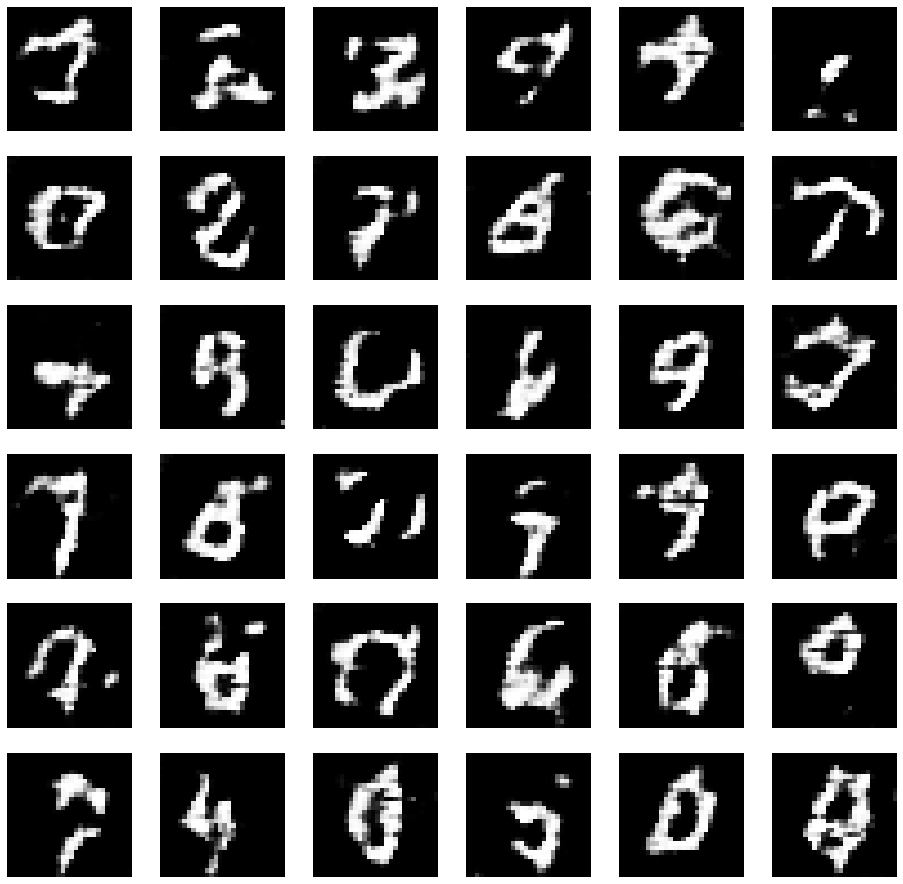

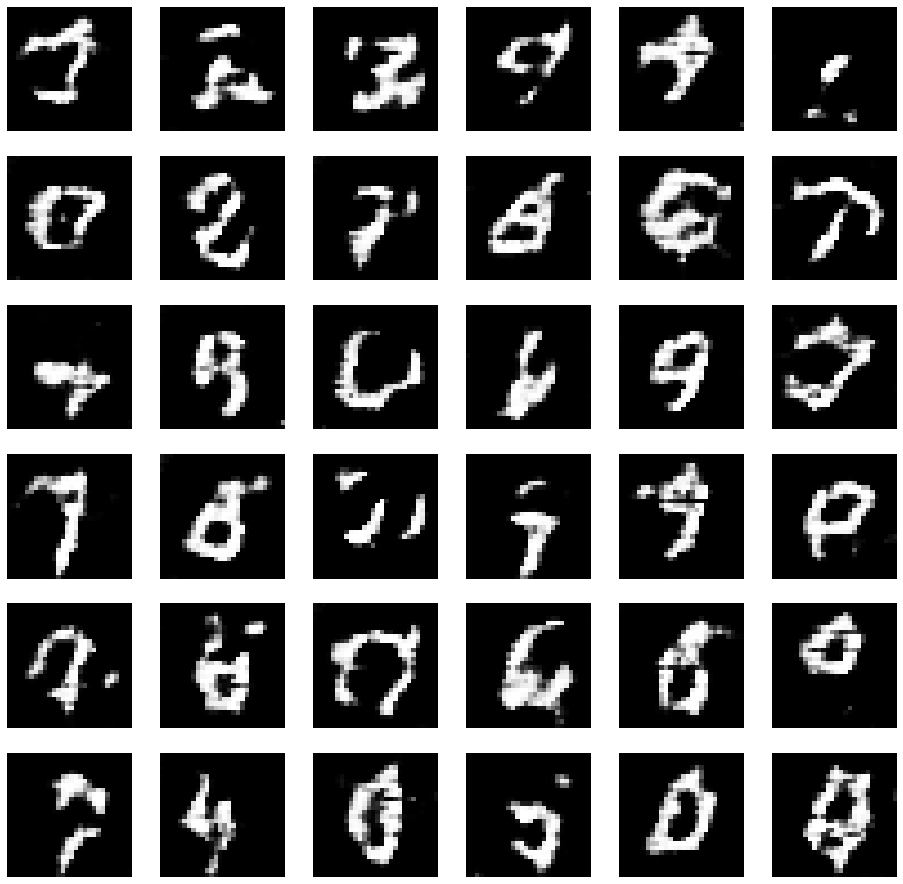

In [35]:
predict()

## 5. Exit strategy

In [0]:
clear = False #@param ["False", "True"] {type:"raw"}
if clear: # Clear directory for logging
  !rm -rf ./logs/ 